In [50]:
import jax.numpy as jnp
from jax import jit
from jax.lax import scan
from scipy.special import erfcx as sc_erfcx
from scipy.special import erfc as sc_erfc
from scipy.special import erf as sc_erf
from scipy.special import wofz as sc_wofz
from jax.scipy.special import erfc
from jax.scipy.special import erf
import numpy as np

In [5]:
#def scan(f, init, xs, length=None):
#  if xs is None:
#    xs = [None] * length
#  carry = init
#  ys = []
#  for x in xs:
#    carry, y = f(carry, x)
#    ys.append(y)
#  return carry, np.stack(ys)

3

In [2]:
##CHECKING
_CHEV_COEFS_=[5.92470169e-5,1.61224554e-4, -3.46481771e-4,-1.39681227e-3,1.20588380e-3, 8.69014394e-3,
        -8.01387429e-3,-5.42122945e-2,1.64048523e-1,-1.66031078e-1, -9.27637145e-2, 2.76978403e-1]
chev=jnp.array(_CHEV_COEFS_)
    
def fmaf(p,q,x):
    return p*q + x

def naive_scan(q):
    p=chev[0]
    for x in chev[1:]:
        p=fmaf(p,q,x)
    return p

def jax_scan(q):
    def fmascan(c,x):
        return c*q + x,None
    p,n = scan(fmascan, 0.0, chev)
    return p

In [35]:
naive_scan(1.3), jax_scan(1.3)

(DeviceArray(0.08934531, dtype=float32),
 DeviceArray(0.08934531, dtype=float32))

In [63]:
jnp.abs(-1)

DeviceArray(1, dtype=int32)

In [146]:
@jit
def erfcx(x):
    """erfcx (float) based on Shepherd and Laframboise (1981)
    
    Params:
        x: should be larger than -9.3
        
    Return:
        f: erfcx(x)
    """
    a=jnp.abs(x)
    q = (-a*(a-2.0)/(a+2.0)-2.0*((a-2.0)/(a+2.0)+1.0)+a)/(a+2.0) + (a-2.0)/(a+2.0)
    
    _CHEV_COEFS_=[5.92470169e-5,1.61224554e-4, -3.46481771e-4,-1.39681227e-3,1.20588380e-3, 8.69014394e-3,
     -8.01387429e-3,-5.42122945e-2,1.64048523e-1,-1.66031078e-1, -9.27637145e-2, 2.76978403e-1]
    chev=jnp.array(_CHEV_COEFS_)
    def fmascan(c,x):
        return c*q + x,None
    p,n = scan(fmascan, 0.0, chev)

    q = (p+1.0)/(1.0+2.0*a)
    d = (p+1.0)-q*(1.0+2.0*a)
    f = 0.5*d/(a+0.5) + q
    
    f=jnp.where(x>=0.0, f, 2.0*jnp.exp(a**2) - f) 
    
    return f

In [162]:
erfcx(-4.0),sc_erfcx(-4.0)

(DeviceArray(17772222., dtype=float32), 17772220.904016286)

In [78]:
%timeit erfcx(1.0)

857 µs ± 124 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit sc_erfcx(1.0)

830 ns ± 63.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [184]:
N=1000
xv=jnp.linspace(-10.0,100.0,N)
xvc=np.linspace(-10.0,100.0,N)

In [156]:
verfcx=vmap(erfcx)
%timeit verfcx(xv)

The slowest run took 4.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1.57 ms ± 613 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
%timeit sc_erfc(xvc)

35.5 µs ± 5.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [185]:
d=(verfcx(xv) - sc_erfcx(xvc))/ sc_erfcx(xvc)

Text(0.5, 0, 'x')

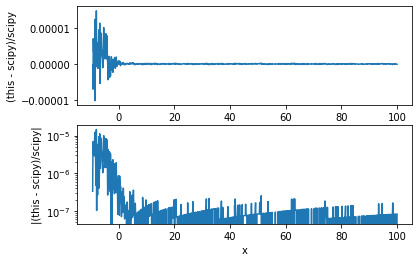

In [195]:
fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xvc,d)
plt.ylabel("(this - scipy)/scipy")
ax=fig.add_subplot(212)
ax.plot(xvc,jnp.abs(d))
plt.ylabel("|(this - scipy)/scipy|")
plt.yscale("log")
plt.xlabel("x")
#plt.yscale("log")
#plt.ylim(1.e-12,1.e3)

In [193]:
erfcx(-9.3)

DeviceArray(7.297299e+37, dtype=float32)